In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from idskicker.config import data_dir

df_start = pd.read_csv(data_dir / 'processed' / '02-ks-projects-engineered.csv')

In [3]:
to_drop = ["ID", "launched", "deadline", 
           "usd_pledged_real", "backers", "launched_year", "deadline_year"]
df = df_start.drop(columns=to_drop)

In [4]:
from sklearn.preprocessing import StandardScaler
mms = StandardScaler()
cols_to_scale = ["launched_hour", "launched_minute", "name_length", 
                 "name_words", "launched_to_deadline_days", "usd_goal_real"]
df[cols_to_scale] = mms.fit_transform(df[cols_to_scale]) 
df["state"] = df["state"].map({"failed":0, "successful":1})
for c in df.select_dtypes("object").columns:
    df[c] = df[c].astype('category')
df.head()

,name,category,main_category,currency,state,country,usd_goal_real,deadline_month,deadline_day,launched_month,launched_day,launched_hour,launched_minute,name_length,name_words,launched_to_deadline_days
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,GB,-0.046297,October,Friday,August,Tuesday,-0.140469,-0.921442,-0.203792,-0.231694,1.972610
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,US,0.008405,November,Wednesday,September,Saturday,-1.177336,0.801718,0.673288,0.881005,2.051404
2,Where is Hank?,Narrative Film,Film & Video,USD,0,US,0.037230,February,Tuesday,January,Saturday,-1.695770,-0.476756,-1.268818,-0.973494,0.869495
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,US,-0.039636,April,Monday,March,Saturday,-1.306945,-0.254412,0.923883,0.510106,-0.312415
4,Monarch Espresso Bar,Restaurants,Food,USD,1,US,0.046838,April,Friday,February,Friday,-0.010861,0.523789,-0.892927,-0.973494,0.081555


In [5]:
from idskicker.features import add_n_most_frequent_words_as_features
df_copy = df.copy()
add_n_most_frequent_words_as_features(df_copy, "name", 10)
df_copy = df_copy.drop(columns=["name"])

[nltk_data] Downloading package wordnet to /home/emil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/emil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
X = df_copy.drop(columns=["state"])
y = df_copy["state"]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [7]:
# Tuner example taken from https://github.com/optuna/optuna/blob/master/examples/lightgbm_tuner_cv.py
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as o_lgb

cat_features = [c for c, col in enumerate(X_train.dtypes) if str(col) == "category"]
d_train = o_lgb.Dataset(X_train, label=y_train, categorical_feature = cat_features)

params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

tuner = o_lgb.LightGBMTunerCV(
    params, d_train, verbose_eval=100000, early_stopping_rounds=100, folds=KFold(n_splits=3), verbosity=-1
)

tuner.run()

[I 2020-12-12 09:02:17,513] A new study created in memory with name: no-name-84a50be7-48b3-418b-9789-6f7e21b4bc7e
/home/emil/anaconda3/lib/python3.8/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:435: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/emil/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
min_data_in_leaf, val_score: 0.761359: 100%|##########| 5/5 [01:07<00:00, 13.43s/it]


In [8]:
tuner.best_params

{'objective': 'binary',
 'metric': 'auc',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 0.0792934225029538,
 'lambda_l2': 8.403689455946852,
 'num_leaves': 16,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.8726087678345507,
 'bagging_freq': 1,
 'min_child_samples': 20}

In [8]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_pre_filter': False,
    'lambda_l1': 0.0792934225029538,
    'lambda_l2': 8.403689455946852,
    'num_leaves': 16,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.8726087678345507,
    'bagging_freq': 1,
    'min_child_samples': 20
}
cat_features = [c for c, col in enumerate(X_train.dtypes) if str(col) == "category"]
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_features)
clf = lgb.train(params, d_train, 1000)

y_pred=[1 if x > 0.5 else 0 for x in clf.predict(X_test)]
accuracy_score(y_test, y_pred)

/home/emil/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.7038359962358465

## Plotting the ROC curve

In [11]:
from sklearn.metrics import roc_curve
X_disc, X_val, y_disc, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=1)
fpr, tpr, threshold = roc_curve(y_val, clf.predict(X_val))
roc_df = pd.DataFrame({"threshold": threshold, "tpr":tpr, "fpr":fpr})
roc_df = roc_df.loc[roc_df["threshold"] < 1].sort_values(by="threshold")

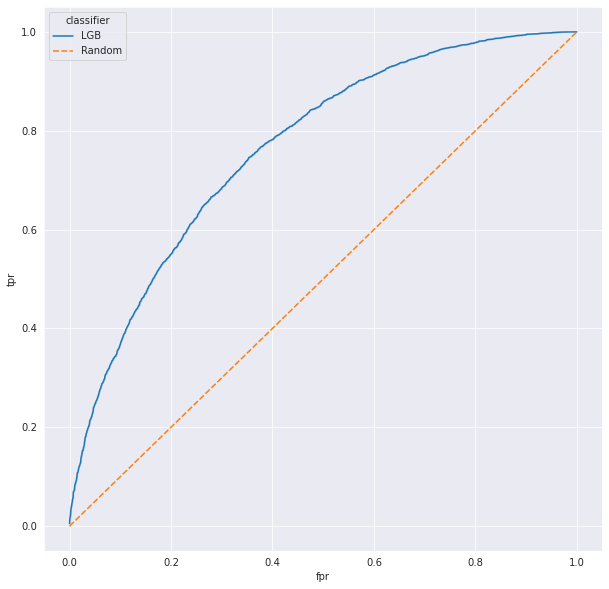

In [12]:
cp_roc_df = roc_df.copy()
cp_roc_df["classifier"] = "LGB"
cp_roc_df = cp_roc_df.append(pd.DataFrame({"threshold":[0,0], 
                  "tpr":[0,1], "fpr": [0,1], 
                  "classifier":["Random", "Random"]}), ignore_index=True)

fig = plt.figure(figsize=(10, 10))
sns.lineplot(x="fpr", y="tpr", hue="classifier", style="classifier", data=cp_roc_df)

In [13]:
roc_df["optimal"] = roc_df["tpr"] - (1 - roc_df["fpr"])
roc_df["optimal"] = abs(roc_df["optimal"])
roc_df.sort_values(by="optimal").head(5)

,threshold,tpr,fpr,optimal
2042,0.415223,0.692562,0.307705,0.000267
2041,0.415450,0.691800,0.307705,0.000495
2043,0.415176,0.692562,0.308042,0.000603
2040,0.415585,0.691800,0.307369,0.000831
2044,0.415087,0.692815,0.308042,0.000857


In [14]:
y_pred=[1 if x > 0.415 else 0 for x in clf.predict(X_test)]
print(classification_report(y_test, y_pred, target_names=["fail", "success"]))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

        fail       0.77      0.69      0.73     58998
     success       0.60      0.70      0.65     39829

    accuracy                           0.69     98827
   macro avg       0.69      0.69      0.69     98827
weighted avg       0.70      0.69      0.70     98827

0.6937982535137159


In [15]:
y_pred=[1 if x > 0.5 else 0 for x in clf.predict(X_test)]
print(classification_report(y_test, y_pred, target_names=["fail", "success"]))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

        fail       0.73      0.80      0.76     58998
     success       0.65      0.56      0.61     39829

    accuracy                           0.70     98827
   macro avg       0.69      0.68      0.68     98827
weighted avg       0.70      0.70      0.70     98827

0.7038359962358465


## Plotting feature importance

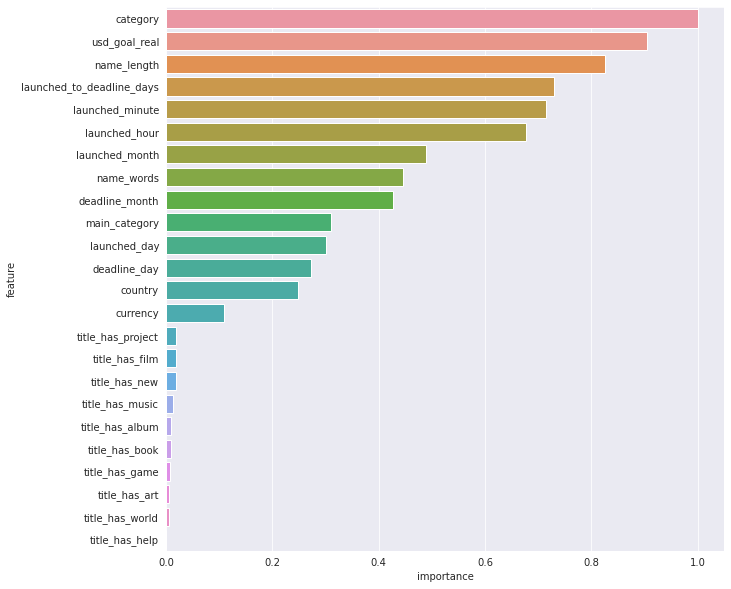

In [29]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
feature_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": clf.feature_importance()
             })

feature_df[["importance"]] = mms.fit_transform(feature_df[["importance"]])
feature_df = feature_df.sort_values(by="importance", ascending=False)

sns.set_style("darkgrid")
fig = plt.figure(figsize=(10, 10))
sns.barplot(y="feature", x="importance", data=feature_df, orient="h")